In [9]:
import struct
import binascii
import hashlib

## Append : Padding bits &  Length bits
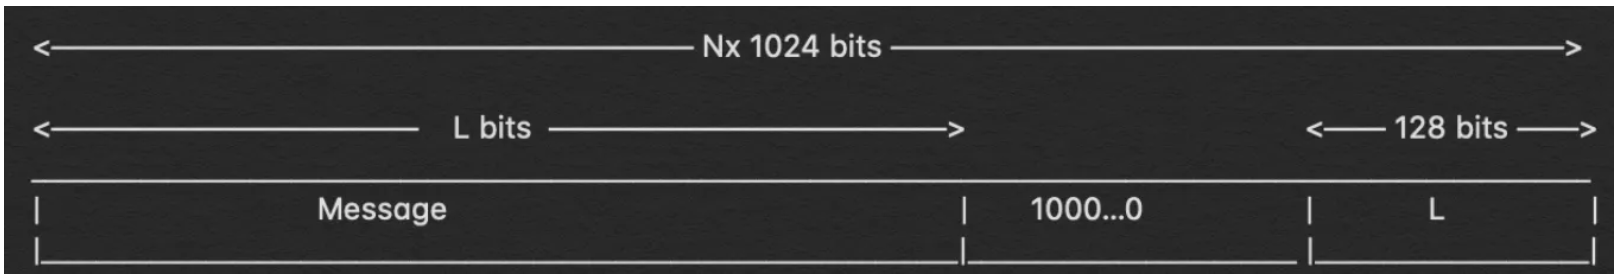

In [12]:
def pad_message(message_bytes):
   
    message_len_bits = len(message_bytes) * 8
    padding = b'\x80' # Append a single '1' bit (represented as byte 0x80)

    # Calculate the number of zero bits/bytes needed
    # Message length + 1 bit ('1') + k zero bits + 128 bits (original length) = N * 1024
    # The total length must be a multiple of 1024 bits (128 bytes)
    # We need space for the 128-bit length field at the end.
    k_bits_needed = (896 - (message_len_bits + 1)) % 1024
    if k_bits_needed < 0: # Handle potential negative result from modulo
         k_bits_needed += 1024

    k_bytes_needed = k_bits_needed // 8
    padding += b'\x00' * k_bytes_needed

    # Append the original message length as a 128-bit big-endian integer
    padding += struct.pack('>Q', 0) # Upper 64 bits (usually 0 unless message > 2^64 bits)
    padding += struct.pack('>Q', message_len_bits) # Lower 64 bits

    return message_bytes + padding


## Initialize the buffers

In [3]:
# Initial Hash Values (H0-H7) - First 64 bits of the fractional parts
# of the square roots of the first 8 primes (2, 3, 5, 7, 11, 13, 17, 19)
H = [
    0x6a09e667f3bcc908, 0xbb67ae8584caa73b, 0x3c6ef372fe94f82b, 0xa54ff53a5f1d36f1,
    0x510e527fade682d1, 0x9b05688c2b3e6c1f, 0x1f83d9abfb41bd6b, 0x5be0cd19137e2179
]

# Round Constants (K0-K79) - First 64 bits of the fractional parts
# of the cube roots of the first 80 primes (2 to 409)
K = [
    0x428a2f98d728ae22, 0x7137449123ef65cd, 0xb5c0fbcfec4d3b2f, 0xe9b5dba58189dbbc,
    0x3956c25bf348b538, 0x59f111f1b605d019, 0x923f82a4af194f9b, 0xab1c5ed5da6d8118,
    0xd807aa98a3030242, 0x12835b0145706fbe, 0x243185be4ee4b28c, 0x550c7dc3d5ffb4e2,
    0x72be5d74f27b896f, 0x80deb1fe3b1696b1, 0x9bdc06a725c71235, 0xc19bf174cf692694,
    0xe49b69c19ef14ad2, 0xefbe4786384f25e3, 0x0fc19dc68b8cd5b5, 0x240ca1cc77ac9c65,
    0x2de92c6f592b0275, 0x4a7484aa6ea6e483, 0x5cb0a9dcbd41fbd4, 0x76f988da831153b5,
    0x983e5152ee66dfab, 0xa831c66d2db43210, 0xb00327c898fb213f, 0xbf597fc7beef0ee4,
    0xc6e00bf33da88fc2, 0xd5a79147930aa725, 0x06ca6351e003826f, 0x142929670a0e6e70,
    0x27b70a8546d22ffc, 0x2e1b21385c26c926, 0x4d2c6dfc5ac42aed, 0x53380d139d95b3df,
    0x650a73548baf63de, 0x766a0abb3c77b2a8, 0x81c2c92e47edaee6, 0x92722c851482353b,
    0xa2bfe8a14cf10364, 0xa81a664bbc423001, 0xc24b8b70d0f89791, 0xc76c51a30654be30,
    0xd192e819d6ef5218, 0xd69906245565a910, 0xf40e35855771202a, 0x106aa07032bbd1b8,
    0x19a4c116b8d2d0c8, 0x1e376c085141ab53, 0x2748774cdf8eeb99, 0x34b0bcb5e19b48a8,
    0x391c0cb3c5c95a63, 0x4ed8aa4ae3418acb, 0x5b9cca4f7763e373, 0x682e6ff3d6b2b8a3,
    0x748f82ee5defb2fc, 0x78a5636f43172f60, 0x84c87814a1f0ab72, 0x8cc702081a6439ec,
    0x90befffa23631e28, 0xa4506cebde82bde9, 0xbef9a3f7b2c67915, 0xc67178f2e372532b,
    0xca273eceea26619c, 0xd186b8c721c0c207, 0xeada7dd6cde0eb1e, 0xf57d4f7fee6ed178,
    0x06f067aa72176fba, 0x0a637dc5a2c898a6, 0x113f9804bef90dae, 0x1b710b35131c471b,
    0x28db77f523047d84, 0x32caab7b40c72493, 0x3c9ebe0a15c9bebc, 0x431d67c49c100d4c,
    0x4cc5d4becb3e42b6, 0x597f299cfc657e2a, 0x5fcb6fab3ad6faec, 0x6c44198c4a475817
]


## Hepler Functions

In [4]:
# --- Helper Functions ---

def rotr(n, b):
    """Right rotate a 64-bit integer n by b bits."""
    return ((n >> b) | (n << (64 - b))) & 0xFFFFFFFFFFFFFFFF

def shr(n, b):
    """Right shift a 64-bit integer n by b bits."""
    return (n >> b) & 0xFFFFFFFFFFFFFFFF

In [5]:
def Ch(x, y, z):
    """Choose function."""
    return (x & y) ^ (~x & z)

def Maj(x, y, z):
    """Majority function."""
    return (x & y) ^ (x & z) ^ (y & z)

def Sigma0(x):
    """As defined in FIPS PUB 180-4 section 4.1.3"""
    return rotr(x, 28) ^ rotr(x, 34) ^ rotr(x, 39)

def Sigma1(x):
    """As defined in FIPS PUB 180-4 section 4.1.3"""
    return rotr(x, 14) ^ rotr(x, 18) ^ rotr(x, 41)

def sigma0(x):
    """As defined in FIPS PUB 180-4 section 4.1.3"""
    return rotr(x, 1) ^ rotr(x, 8) ^ shr(x, 7)

def sigma1(x):
    """As defined in FIPS PUB 180-4 section 4.1.3"""
    return rotr(x, 19) ^ rotr(x, 61) ^ shr(x, 6)


## Compression Function

In [6]:
def calculate_sha512(data_string):
    # 1. Encode the input string to bytes
    message_bytes = data_string.encode('utf-8')

    # 2. Pad the message
    padded_message = pad_message(message_bytes)

    # 3. Initialize hash values (make a copy to modify)
    h = list(H)

    # 4. Process the message in 1024-bit (128-byte) chunks
    block_size = 128
    num_blocks = len(padded_message) // block_size

    for i in range(num_blocks):
        # Get the current block
        block_start = i * block_size
        block = padded_message[block_start : block_start + block_size]

        # Prepare the message schedule (W[0...79])
        w = [0] * 80
        # First 16 words are from the block directly (64-bit words, big-endian)
        for t in range(16):
            offset = t * 8
            w[t] = struct.unpack('>Q', block[offset : offset + 8])[0]

        # Extend the first 16 words into the remaining 64 words
        for t in range(16, 80):
            s0 = sigma0(w[t-15])
            s1 = sigma1(w[t-2])
            w[t] = (w[t-16] + s0 + w[t-7] + s1) & 0xFFFFFFFFFFFFFFFF # Modulo 2^64

        # Initialize working variables for this block
        a, b, c, d, e, f, g, hh = h # Use hh to avoid conflict with loop variable h

        # Compression function main loop (80 rounds)
        for t in range(80):
            S1 = Sigma1(e)
            ch = Ch(e, f, g)
            temp1 = (hh + S1 + ch + K[t] + w[t]) & 0xFFFFFFFFFFFFFFFF # Modulo 2^64

            S0 = Sigma0(a)
            maj = Maj(a, b, c)
            temp2 = (S0 + maj) & 0xFFFFFFFFFFFFFFFF # Modulo 2^64

            # Update working variables
            hh = g
            g = f
            f = e
            e = (d + temp1) & 0xFFFFFFFFFFFFFFFF # Modulo 2^64
            d = c
            c = b
            b = a
            a = (temp1 + temp2) & 0xFFFFFFFFFFFFFFFF # Modulo 2^64

        # Compute the intermediate hash values (update H0-H7)
        h[0] = (h[0] + a) & 0xFFFFFFFFFFFFFFFF
        h[1] = (h[1] + b) & 0xFFFFFFFFFFFFFFFF
        h[2] = (h[2] + c) & 0xFFFFFFFFFFFFFFFF
        h[3] = (h[3] + d) & 0xFFFFFFFFFFFFFFFF
        h[4] = (h[4] + e) & 0xFFFFFFFFFFFFFFFF
        h[5] = (h[5] + f) & 0xFFFFFFFFFFFFFFFF
        h[6] = (h[6] + g) & 0xFFFFFFFFFFFFFFFF
        h[7] = (h[7] + hh) & 0xFFFFFFFFFFFFFFFF

    # 5. Concatenate the final hash values
    final_hash_bytes = b''.join(struct.pack('>Q', val) for val in h)

    # 6. Return as hexadecimal string
    return binascii.hexlify(final_hash_bytes).decode('utf-8')


In [7]:
input_text = "This is the data to hash using SHA-512."

In [8]:
sha512_scratch_result = calculate_sha512(input_text)

print(f"Input String: '{input_text}'")
print(f"SHA-512 Hash (from scratch): {sha512_scratch_result}")
print(f"Hash Length (characters): {len(sha512_scratch_result)}")

Input String: 'This is the data to hash using SHA-512.'
SHA-512 Hash (from scratch): 8fa60bf36ea065724612af56578778671569cb4256e69f12548e1bb4c4e40c5f1b5c92b2a9bab52c3e35aeb352c96f1bb49075db2e7855516e6417dc73fcf2dc
Hash Length (characters): 128


In [10]:
sha512_hashlib_result = hashlib.sha512(input_text.encode('utf-8')).hexdigest()
print(f"SHA-512 Hash (hashlib):    {sha512_hashlib_result}")

SHA-512 Hash (hashlib):    8fa60bf36ea065724612af56578778671569cb4256e69f12548e1bb4c4e40c5f1b5c92b2a9bab52c3e35aeb352c96f1bb49075db2e7855516e6417dc73fcf2dc


## Comparision

In [11]:
print(f"Results Match: {sha512_scratch_result == sha512_hashlib_result}")

Results Match: True
